In [10]:
import os,sys
sys.path.append(os.path.abspath(".."))

In [11]:
from core.modeling.base import BaseModel,Config
from core.modeling.ncf import NCFParams,NCFState

import torch,json,pathlib
import numpy as np
import pandas as pd
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from core.utils import seed_all, exclude, read_csv, to_csv
from core.data import load_ds, preprocess,normalize

import seaborn as sns
sns.set_theme(style="darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
seed_all(seed)
new_model = True

In [12]:
paths = ["movies", "users", "ratings", "cols"]
filename = "ncf.pt"

def topath(p):
    return f"ncf_ml_{p}.csv"

In [13]:
# if not new_model and pathlib.Path(topath(paths[0])).exists():
#     movies, users, ratings, cols = [read_csv(topath(p)) for p in paths]
#     movie_cat_cols, movie_num_cols, user_cat_cols, user_num_cols = [json.loads(i) for i in cols[
#         ["movie_cat_cols", "movie_num_cols", "user_cat_cols", "user_num_cols"]
#     ].iloc[0].values.tolist()]
#     print("Loaded")
# else:
movies, ratings = load_ds(2_000_000, 2_000_000)
movies, users, movie_cols, user_cols = preprocess(movies, ratings, add_user_avg_rating=False, add_movie_avg_rating=False)
(movie_cat_cols, movie_num_cols), (user_cat_cols, user_num_cols) = movie_cols, user_cols

cols = pd.DataFrame(dict(
    movie_cat_cols=json.dumps(movie_cat_cols),
    movie_num_cols=json.dumps(movie_num_cols),
    user_cat_cols=json.dumps(user_cat_cols),
    user_num_cols=json.dumps(user_num_cols),
), index=[0])
for df, p in zip([movies, users, ratings, cols], paths):
    to_csv(df, topath(p))

n_users = users.user.nunique()
n_movies = movies.movie.nunique()
extra = NCFState(
    n_users=n_users,
    n_movies=n_movies,
    movie_cat_cols=movie_cat_cols,
    movies_path=topath("movies"),
    users_path=topath("users"),
)
# extra.to_dict()

In [14]:
ratings.rename(columns={
    "movie": "__movieId",
    "user": "__userId",
}, inplace=True)
# ratings

In [15]:
ds = ratings.merge(movies, on="__movieId",).merge(users, how="left", on="__userId")
ds = normalize(ds, ["rating"])
ds.drop(columns=["__movieId","__userId"],inplace=True)
ds = ds.sample(frac=1, random_state=seed)
# ds.head()

In [16]:
class DS(torch.utils.data.Dataset):
    def __init__(self, users, movies, genres, y) -> None:
        super().__init__()
        self.y = y
        self.users = users
        self.movies = movies
        self.genres = genres

    def __len__(self):
        l = self.y.shape[0]
        return l

    def __getitem__(self, index):
        users = self.users[index]
        movies = self.movies[index]
        genres = self.genres[index]
        y = self.y[index]
        return dict(
            users=users,
            movies=movies,
            genres=genres,
            y=y,
        )



batch_size = 64*20
train_ds, valid_ds,test_ds = torch.utils.data.random_split(
    DS(
        ds.user.astype(np.int32).values,
        ds.movie.astype(np.int32).values,
        ds[exclude(movie_cat_cols,"movie","year_bin")].astype(np.int32).values,
        ds.rating.astype(np.float32).values,
    ),
    [.8, .1,.1]
)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size)
# ds.head()
# (u,m,g),y = next(iter(valid_dl))
# u.shape,m.shape,g.shape,y.shape

In [17]:
if not new_model and pathlib.Path(filename).exists():
    model,optimizer,training_result = BaseModel.load(
        filename,
    )
else:
    model = BaseModel.init_model(
        Config(
            model_name="NCF",
            lr=.001,
            params=NCFParams(
                nu=n_users,
                nm=n_movies,
                u_embd=32,
                m_embd=32,
                genres_embd=16,
                hidden_layers=[32, 32, 32],
                p=.2
            ),
            extra=extra.to_dict()
        )
    ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), model.config.lr, weight_decay=0.01)
    training_result = None

model.numel()

3216224

In [18]:
epochs = 1
patience = 5
training_result = model.fit(
    optimizer,
    train_dl,
    loss_fn=F.mse_loss,
    metric=root_mean_squared_error,
    epochs=epochs,
    val_ld=valid_dl,
    patience=patience,
    last_training_result=training_result,
)

Epoch:  1, loss : 0.0350, val_loss: 0.0347: 100%|██████████| 1250/1250 [00:19<00:00, 63.17it/s]


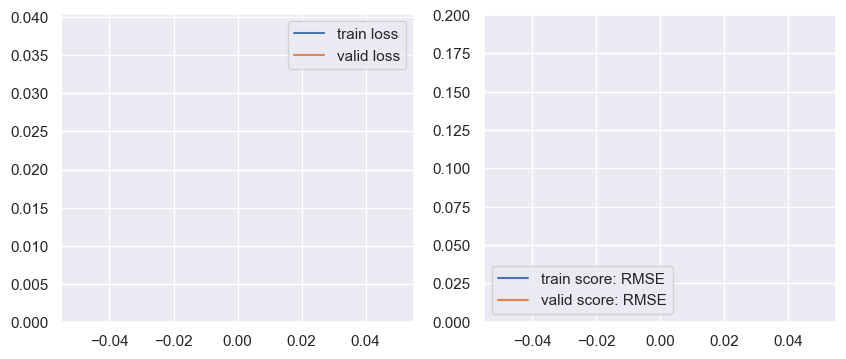

In [19]:
training_result.plot(score_name="RMSE")

In [20]:
test = test_ds[:None]
pred = model.recommend_for_users(
    **test,
    sort=False,
    wrap=False,
)
test = pd.DataFrame(
    dict(pred=pred, rating=test["y"], user=test["users"], movie=test["movies"]))
test["rating"] = test["rating"] * 5
test["error"] = test.rating - test.pred

print(f"True: mean {test.rating.mean():.3}, std {test.rating.std():.3}")
print(f"Pred: mean {test.pred.mean():.3}, std {test.pred.std():.3}")
print(f"RSME: {root_mean_squared_error(test.rating,test.pred)}")
test[["user", "movie", "rating", "pred", "error"]].head()

True: mean 3.54, std 1.06
Pred: mean 3.46, std 0.457
RSME: 0.9274127300299615


,user,movie,rating,pred,error
0,9465,2203,3.5,2.924613,0.575387
1,3134,18232,3.0,2.828413,0.171587
2,5710,3780,3.0,3.495776,-0.495776
3,10421,15240,4.5,3.686484,0.813516
4,9368,375,4.0,3.734951,0.265049


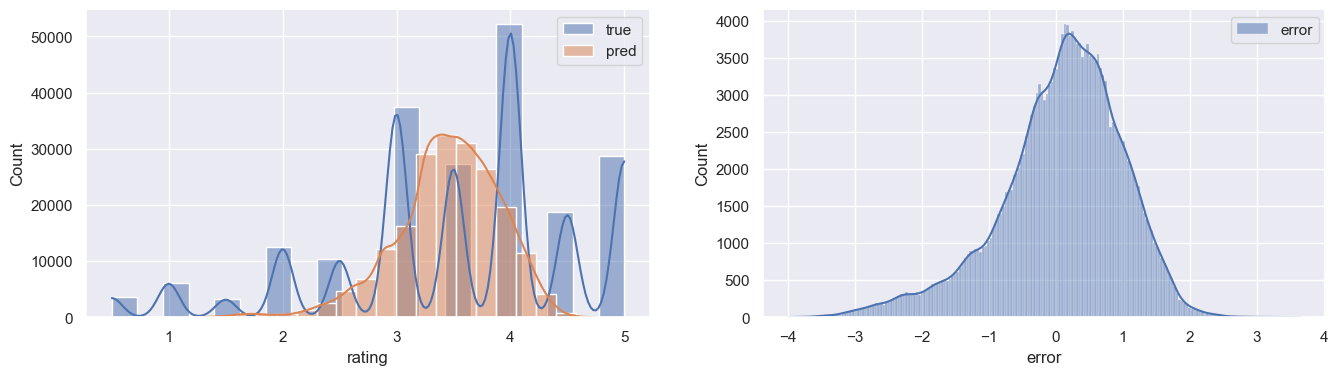

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(test.rating, fill=True, label="true", ax=ax1, bins=20, kde=True)
sns.histplot(test.pred, fill=True, label="pred", ax=ax1, bins=20, kde=True)
sns.histplot(test.error, fill=True, label="error", ax=ax2, kde=True)
ax1.legend();
ax2.legend();

In [22]:
model.save(
    filename,
    optimizer=optimizer,
    last_training_result=training_result,
    extra=extra.to_dict()
)

Model saved.


In [23]:
model.recommend_for_users(**model.prepare(3, [55, 300]), sort=True)

[Recommendation(userId=3, movieId=300, predicted_rating=3.1857852935791016),
 Recommendation(userId=3, movieId=55, predicted_rating=3.0776870250701904)]